<font size="6">**InteRFACE Data Package Workflow**</font>

**Objective:**  
* Download all needed data inputs for a ATS + MOSART run on a Sag River HUC.
* Process raw huc data and generate mesh.
* Generate a data package in a purely automated way.

In [1]:
import sys,os
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.optimize, scipy.signal, scipy.stats
import collections
import logging
import fiona, rasterio, shapely
import rasterio.warp

import workflow
import workflow.crs
import workflow.warp
import workflow.source_list
import workflow.utils
import workflow.ui
import workflow.conf
import workflow.mesh

import hillslopes
import landcover
import meshing
import plot

# Processing preparation

## Input for this worksheet

In [2]:
# the HUC to delineate
huc = '190604020404'

# contributing area, in pixels?  [m^2]? used to provide a lower bound on pixels
# that are included in the stream network 
streams_contributing_area_cutoff = -1 

# target, in pixels, of the subcatchment size
target_subcatchment_size = 20000

# number of horizontal grid cells in the hillslope
hillslope_bin_dx = 100
mesh_dx = 20
toeslope_min_slope = 0.0
hillslope_min_slope = 0.1

#Don't let individual areas get too small in width -- 10% mean as a min value?
min_area_ratio = 0.1

# Refine mesh area no larger than refine_max_area
refine_max_area = 1000

# what fraction of the total flowpath lengths do we want to include?
#
# Effectively, some small number of pixels are often a long way away from the stream
# (whether this is real or artifact).  We don't need tiny cells up at the top of the
# hillslope.  Maybe keep 95% of the flowpath length?
hillslope_keep_fraction = 0.95

# demo subcatchment
subcatch_demo_id = 35

# The top level directory where these packages will go, one subdirectory for each HUC/data package
package_directory = '../huc'

## Set up directory

In [3]:
# directory for one huc
huc_dir = os.path.join(package_directory,f'{huc}')
if not os.path.isdir(huc_dir):
    os.mkdir(huc_dir)

# directory of raw hillslope data for this huc, downloaded from USGS
hillslope_raw_dir = os.path.join(huc_dir, 'data_raw-hillslope')
if not os.path.isdir(hillslope_raw_dir):
    os.mkdir(hillslope_raw_dir)
    
# directory of preprocessed hillslope data for meshing in this huc
pp_hillslope_dir = os.path.join(huc_dir, 'data_preprocessed-meshing')
if not os.path.isdir(pp_hillslope_dir):
    os.mkdir(pp_hillslope_dir)
    
# directory of generated meshes
mesh_dir = os.path.join(huc_dir, 'mesh')
if not os.path.isdir(mesh_dir):
    os.mkdir(mesh_dir)
        
# directory of raw daymet data for this huc
daymet_raw_dir = os.path.join(huc_dir, 'data_raw-daymet')
if not os.path.isdir(daymet_raw_dir):
    os.mkdir(daymet_raw_dir)    

# directory of processed daymet data for this huc
daymet_dir = os.path.join(huc_dir, 'daymet')
if not os.path.isdir(daymet_dir):
    os.mkdir(daymet_dir)

## Set up data source and watershed_workflow

In [4]:
target_crs = workflow.crs.default_alaska_crs()
raster_extension = 'tif'

# data sources
data_sources = dict()
data_sources['huc'] = workflow.source_list.huc_sources['WBD']  
data_sources['dem'] = workflow.source_list.dem_sources['NED 1 arc-second']

# set up watershed_workflow
workflow.ui.setup_logging(1)
workflow.conf.rcParams['DEFAULT']['data_directory'] = hillslope_raw_dir

## Set up filenames needed in data package

In [5]:
filenames = hillslopes.get_filenames(huc, huc_dir)
# print(filenames)

# Acquire HUC shapefile and DEM from USGS

## Download and conversion

In [6]:
# download (if necessary) the HUC shapefile
huc_crs, huc_shape = workflow.get_huc(data_sources['huc'], huc)

# download (if necessary) the DEM
dem_profile, dem_raster = workflow.get_raster_on_shape(data_sources['dem'], 
                                                       huc_shape, huc_crs, 
                                                       mask=True, nodata=np.nan)
# convert rasterio crs to workfkow standard crs
native_crs = workflow.crs.from_rasterio(dem_profile['crs'])

# project the shapefile into the native CRS
huc_shape = workflow.warp.shply(huc_shape, huc_crs, native_crs)

2021-10-01 10:56:12,437 - root - INFO: 
2021-10-01 10:56:12,438 - root - INFO: Loading HUC 190604020404
2021-10-01 10:56:12,439 - root - INFO: ------------------------------
2021-10-01 10:56:12,440 - root - INFO: 
2021-10-01 10:56:12,441 - root - INFO: Loading level 12 HUCs in 190604020404
2021-10-01 10:56:12,441 - root - INFO: ------------------------------
2021-10-01 10:56:12,443 - root - INFO: Using HUC file "../huc/190604020404/data_raw-hillslope/hydrography/WBD_19_GDB/WBD_19.gdb"
2021-10-01 10:56:14,729 - root - INFO: ... found 1 HUCs
2021-10-01 10:56:14,730 - root - INFO:   -- 190604020404
2021-10-01 10:56:14,740 - root - INFO: Converting to shapely
2021-10-01 10:56:14,741 - root - INFO: ... found 1
2021-10-01 10:56:14,742 - root - INFO: 
2021-10-01 10:56:14,742 - root - INFO: Loading Raster
2021-10-01 10:56:14,743 - root - INFO: ------------------------------
2021-10-01 10:56:14,743 - root - INFO: Collecting raster
2021-10-01 10:56:14,777 - root - INFO: Collecting DEMs to tile b

## Validate: plot DEM and HUC shape

In [7]:
fig_property = dict()
fig_property['figsize'] = (12,4)
fig_property['dpi'] = 80
fig, ax = workflow.plot.get_ax(native_crs, **fig_property)
workflow.plot.dem(dem_profile, dem_raster, ax=ax)
workflow.plot.shply([huc_shape,], native_crs, ax=ax)
plt.show()

## Save DEM and HUC shape files do disk

In [8]:
if not os.path.isfile(filenames['huc']):
    hillslopes.save_shapefile(filenames['huc'], [huc_shape,], native_crs)          

if not os.path.isfile(filenames['dem']):
    hillslopes.save_demfile(filenames['dem'], dem_profile, dem_raster)

# Delineate subcatchments and flowpaths

## Subcatchments and flowpaths source

In [9]:
# NOTE: this needs to be added by Jon!
#
# At this point, we need:
assert(os.path.isfile(filenames['subcatchments'])) # subcatchment shapefile
assert(os.path.isfile(filenames['streams_raster'])) # streams raster
assert(os.path.isfile(filenames['aspect'])) # aspect raster
assert(os.path.isfile(filenames['slope'])) # slope raster
assert(os.path.isfile(filenames['flowpath_length'])) # raster of each pixel's distance to the stream
assert(os.path.isfile(filenames['elev_above_streams'])) # raster of HAND

## Load all subcatchments and flowpaths from source

In [10]:
_, subcatchments = workflow.get_shapes(filenames['subcatchments'], out_crs=native_crs)
print(f'Numbers of subcatchments in basin-{huc}: ', len(subcatchments))

2021-10-01 10:56:14,981 - root - INFO: 
2021-10-01 10:56:14,983 - root - INFO: Loading shapes
2021-10-01 10:56:14,985 - root - INFO: ------------------------------
2021-10-01 10:56:14,987 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-10-01 10:56:15,001 - root - INFO: ... found 44 shapes
2021-10-01 10:56:15,002 - root - INFO: Converting to shapely
2021-10-01 10:56:15,023 - root - INFO: Converting to requested CRS


Numbers of subcatchments in basin-190604020404:  44


## Validate: plot subcatchments and flowpaths

In [11]:
fig_property = dict()
fig_property['figsize'] = (12,4)
fig_property['dpi'] = 80
fig, ax = workflow.plot.get_ax(native_crs, **fig_property)
workflow.plot.dem(dem_profile, dem_raster, ax=ax)
workflow.plot.shply(workflow.utils.flatten(subcatchments),
                    native_crs, ax=ax, color='r')
plt.show()

# Land cover

## Project NNSI land cover and save to disk

In [12]:
# if not os.path.isfile(filenames['land_cover']):
#     landcover.reprojectLandCover(dem_profile, nssiImg_filename, filenames['land_cover'])
# Comment because no NSSI land cover map data

## Validate: plot land cover 

In [13]:
lc_profile, lc_raster = workflow.get_raster_on_shape(filenames['land_cover'],
                                                     huc_shape, huc_crs, 
                                                     mask=True, nodata=np.nan)
fig_property = dict()
fig_property['figsize'] = (12,4)
fig_property['dpi'] = 80

fig, ax = workflow.plot.get_ax(native_crs, **fig_property)
land_cover = workflow.plot.raster(lc_profile, lc_raster, ax=ax)
workflow.plot.shply([huc_shape,], native_crs, ax=ax)
# fig.colorbar(land_cover)
plt.show()

# Determine hillslopes geometry based on flowpaths

**Objective:**  
* Determine a single hillslope profile geometry for each subcatchment (44 in total).

**Objects to obtain:**  
* hillslope length
* an elevation profile along that length
* a width along that length

**Main idea:**
* Regard each subcatchment as a single flowpath, with average properties.

**Method:**  
* Route the surface flow and generate a standard D8<sup>[1]</sup> flowpath direction vector for each pixel of the (smoothed and filled) DEM.
* Form rasters comprising of "length along the flowpath to the stream network" and the corresponding "height above the stream network."
* Bin the rasters according to the flowpath length.
* Average pixels in each bin to determine:
    - hillslope length = 90th % of the maximum flowpath length
    - bins as a function of flowpath length
    - elevation as a function of bin
    - number of pixels in each bin gives an area



**Notes**  
[1] There are eight valid output directions relating to the eight adjacent cells into which flow could travel. This approach is commonly referred to as an [eight-direction (D8) flow model](https://pro.arcgis.com/en/pro-app/latest/tool-reference/raster-analysis/flow-direction.htm). This method models flow direction from each cell to its steepest downslope neighbor. The output is an integer raster whose values range from 1 to 255. The number denotes the flowpath.

## Get hillslope parameters for one subcatchment 

2021-10-01 10:56:15,081 - root - INFO: 
2021-10-01 10:56:15,081 - root - INFO: Loading shapes
2021-10-01 10:56:15,082 - root - INFO: ------------------------------
2021-10-01 10:56:15,083 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-10-01 10:56:15,087 - root - INFO: ... found 44 shapes
2021-10-01 10:56:15,088 - root - INFO: Converting to shapely
2021-10-01 10:56:15,141 - root - INFO: 
2021-10-01 10:56:15,142 - root - INFO: Loading Raster
2021-10-01 10:56:15,143 - root - INFO: ------------------------------
2021-10-01 10:56:15,143 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-10-01 10:56:15,144 - root - INFO: Collecting raster
2021-10-01 10:56:15,190 - root - INFO: ... got raster of shape: (130, 305)
2021-10-01 10:56:15,200 - root - INFO: Masking to shape
2021-10-01 10:56:15,232 - root - INFO:   shape bounds: (-149.21512726962825, 68.168421182

bounds in my_crs: (-149.21512726962825, 68.16842118282744, -149.13040504740323, 68.20425451616197)


2021-10-01 10:56:15,289 - root - INFO: ... got raster of shape: (130, 305)
2021-10-01 10:56:15,298 - root - INFO: Masking to shape
2021-10-01 10:56:15,328 - root - INFO:   shape bounds: (-149.21512726962825, 68.16842118282744, -149.13040504740323, 68.20425451616197)
2021-10-01 10:56:15,330 - root - INFO:   casting mask of dtype: float32 to: -999.0
2021-10-01 10:56:15,331 - root - INFO: ... got raster bounds: (-149.21512726962825, 68.20453229393975, -149.13040504740323, 68.16842118282744)
2021-10-01 10:56:15,335 - root - INFO: 
2021-10-01 10:56:15,335 - root - INFO: Loading Raster
2021-10-01 10:56:15,336 - root - INFO: ------------------------------
2021-10-01 10:56:15,337 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_aspect.tif'
2021-10-01 10:56:15,339 - root - INFO: Collecting raster
2021-10-01 10:56:15,388 - root - INFO: ... got raster of shape: (130, 305)


bounds in my_crs: (-149.21512726962825, 68.16842118282744, -149.13040504740323, 68.20425451616197)
bounds in my_crs: (-149.21512726962825, 68.16842118282744, -149.13040504740323, 68.20425451616197)


2021-10-01 10:56:15,398 - root - INFO: Masking to shape
2021-10-01 10:56:15,434 - root - INFO:   shape bounds: (-149.21512726962825, 68.16842118282744, -149.13040504740323, 68.20425451616197)
2021-10-01 10:56:15,437 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-10-01 10:56:15,438 - root - INFO: ... got raster bounds: (-149.21512726962825, 68.20453229393975, -149.13040504740323, 68.16842118282744)
2021-10-01 10:56:15,442 - root - INFO: 
2021-10-01 10:56:15,443 - root - INFO: Loading Raster
2021-10-01 10:56:15,444 - root - INFO: ------------------------------
2021-10-01 10:56:15,444 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-10-01 10:56:15,445 - root - INFO: Collecting raster
2021-10-01 10:56:15,493 - root - INFO: ... got raster of shape: (130, 305)
2021-10-01 10:56:15,503 - root - INFO: Masking to shape
2021-10-01 10:56:15,536 - root - INFO:   shape bounds: (-149.21512726962825, 68.16842118282744, -

bounds in my_crs: (-149.21512726962825, 68.16842118282744, -149.13040504740323, 68.20425451616197)
error:  0.0002331351861357689


/Users/3hg/opt/anaconda3/envs/watershed_workflow/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


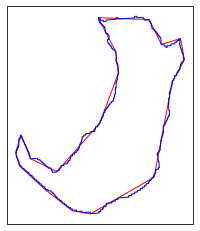

In [14]:
hillslope_demo_pars = hillslopes.parameterizeSubcatchment(
    filenames, huc, subcatch_demo_id,
    target_crs=target_crs,
    hillslope_keep_fraction=hillslope_keep_fraction,
    hillslope_bin_dx=hillslope_bin_dx,
    plot_smoothed=True)

mesh_demo_pars = meshing.parameterizeMesh(hillslope_demo_pars, mesh_dx,
                                          toeslope_min_slope=toeslope_min_slope,
                                          hillslope_min_slope=hillslope_min_slope,
                                          min_area_ratio=min_area_ratio)

# print(hillslope.keys())

## Validate: plot the hillslope

In [15]:
# fig = plt.figure(figsize=(6,8))
# plt.tight_layout()
# gs = gridspec.GridSpec(4,1)
# axs = [fig.add_subplot(gs[2,0]), fig.add_subplot(gs[3,0])]
# plot.plot(hillslope_demo_pars, mesh_demo_pars, fig=fig, axs=axs)


# ax0 = workflow.plot.get_ax(native_crs, fig, axgrid=gs[0,:])
# workflow.plot.raster(hillslope_demo_pars['raster_profile'], hillslope_demo_pars['bins'],
#                      ax=ax0, cmap='prism')
# subcatch_demo = hillslope_demo_pars['subcatchment']
# subcatch_crs_demo = hillslope_demo_pars['subcatchment_target_crs']
# workflow.plot.shply(subcatch_demo, subcatch_crs_demo, ax=ax0, color='k')
# ax0.set_title(f'subcatchment {subcatch_demo_id}')

# ax1 = workflow.plot.get_ax(native_crs, fig, axgrid=gs[1,:])
# vmin, vmax = min(hillslope_demo_pars['land_cover']), max(hillslope_demo_pars['land_cover'])
# cmap = plt.get_cmap(('viridis'),vmax-vmin+1)
# lc = workflow.plot.raster(hillslope_demo_pars['raster_profile'],
#                           hillslope_demo_pars['land_cover_raster'], 
#                           ax=ax1, vmin=vmin-0.5, vmax=vmax+0.5, cmap=cmap)
# workflow.plot.shply(subcatch_demo, subcatch_crs_demo, ax=ax1, color='k')
# position=fig.add_axes([0.95, 0.55, 0.02,0.1])

# fig.colorbar(lc,ticks=np.arange(vmin,vmax+1),cax=position)

# plt.show()

## Get parameters for all hillslopes

In [16]:
# hillslope_pars = []
# mesh_pars = []
# subcatch_all_ids = 1+np.arange(len(subcatchments))
# for subcatch_id in subcatch_all_ids:
#     hillslope_pars.append(hillslopes.parameterizeSubcatchment(
#         filenames, huc, subcatch_id,
#         target_crs=target_crs,
#         hillslope_keep_fraction=hillslope_keep_fraction,
#         hillslope_bin_dx=hillslope_bin_dx))
    
# for i in range(len(hillslope_pars)):    
#     mesh_pars.append(meshing.parameterizeMesh(hillslope_pars[i], mesh_dx,
#                                               toeslope_min_slope=toeslope_min_slope,
#                                               hillslope_min_slope=hillslope_min_slope,
#                                               min_area_ratio=min_area_ratio))

## Plot all hillslopes

In [17]:
# fig = plt.figure(figsize=(20,30),dpi=80)
# nx, ny = 6,8
# sep=0.02

# axs = []
# for i in range(nx):
#     for j in range(ny):
#         sub_id = i*ny+j+1
#         if sub_id > len(subcatchments):
#             continue
        
#         gs = gridspec.GridSpec(4,1,bottom=j/ny+sep, left=i/nx+sep, 
#                                top=(j+1)/ny - sep, right=(i+1)/nx - sep)
#         ax1 = fig.add_subplot(gs[2,0])
#         ax2 = fig.add_subplot(gs[3,0])
#         axs = [ax1,ax2]
#         h_par = hillslope_pars[sub_id-1]
#         m_par = mesh_pars[sub_id-1]        
#         plot.plot(h_par, m_par, fig=fig, axs=axs)
        
#         ax0 = workflow.plot.get_ax(native_crs, fig, axgrid=gs[0,0])
#         ax0.set_title(f'subcatchment {sub_id}')
#         workflow.plot.raster(hillslope_pars[sub_id-1]['raster_profile'], 
#                              hillslope_pars[sub_id-1]['bins'], ax=ax0, cmap='prism')
#         subcatch = hillslope_pars[sub_id-1]['subcatchment']
#         subcatch_crs = hillslope_pars[sub_id-1]['subcatchment_target_crs']            
#         workflow.plot.shply(subcatch, subcatch_crs, ax=ax0, color='k')
        
#         ax1 = workflow.plot.get_ax(native_crs, fig, axgrid=gs[1,0])
#         vmin = min(hillslope_pars[sub_id-1]['land_cover']) 
#         vmax = max(hillslope_pars[sub_id-1]['land_cover'])
#         cmap = plt.get_cmap(('viridis'),vmax-vmin+1)
#         lc = workflow.plot.raster(hillslope_pars[sub_id-1]['raster_profile'], 
#                                   hillslope_pars[sub_id-1]['land_cover_raster'], 
#                                   ax=ax1, vmin=vmin-0.5, vmax=vmax+0.5, cmap=cmap)
#         workflow.plot.shply(subcatch, subcatch_crs, ax=ax1, color='k')
#         position=fig.add_axes([i/nx+sep+0.13, j/ny+sep+0.045, 0.006,0.04])

#         fig.colorbar(lc,ticks=np.arange(vmin,vmax+1),cax=position)

# plt.tight_layout()
# plt.show()

# Generate mesh

In [18]:
layer_info = meshing.layeringStructure(organic_cells=30, organic_cell_dz=0.02, 
                      increase2depth=9.4, increase_cells=20, largest_dz=2.0,
                      bottom_depth=46)
layer_types, layer_data, layer_ncells = layer_info

## Column spinup mesh

In [19]:
# if os.path.isfile(os.path.join(mesh_dir,'column.exo')):
#     os.remove(os.path.join(mesh_dir,'column.exo'))
# colum_mesh = meshing.createColumnMesh(layer_info, 
#                                       os.path.join(mesh_dir,'column.exo'))

## 2D for a given subcatchment

In [20]:
# m2 = meshing.createHillslopeMesh2D(mesh_demo_pars)
# m3 = meshing.createHillslopeMesh3D(m2, mesh_demo_pars, layer_info,
#                                    os.path.join(mesh_dir,f'sag_hillslope{subcatch_demo_id}.exo'))

## 3D for a given subcatchment

In [21]:
subcatch_demo = hillslope_demo_pars['subcatchment']
subcatch_demo_smooth = hillslope_demo_pars['subcatchment_smooth']
subcatch_crs_demo = hillslope_demo_pars['subcatchment_target_crs']

nodem, m2, lc = meshing.createSubcatchmentMesh2D(filenames, subcatch_demo_smooth,
                                                 subcatch_crs_demo, mesh_demo_pars,
                                                 refine_max_area = refine_max_area, plot=True)
if nodem > 0:
    _, m2, lc = meshing.createSubcatchmentMesh2D(filenames, subcatch_demo,
                                                 subcatch_crs_demo, mesh_demo_pars,
                                                 refine_max_area = refine_max_area, plot=True)

m3 = meshing.createSubcatchmentMesh3D(m2, lc, layer_info,
                                      os.path.join(mesh_dir, 
                                                   f'sag_subcatchment{subcatch_demo_id}.exo'))

## 2D for all subcatchments

In [23]:
# subcatch_all_ids = np.arange(1, len(subcatchments)+1)
# for subcatch_id in subcatch_all_ids:
#     index = subcatch_id - 1
#     m2 = meshing.createHillslopeMesh2D(mesh_pars[index])
#     m3 = meshing.createHillslopeMesh3D(m2, mesh_pars[index], meshing.layeringStructure(),
#                                        os.path.join(mesh_dir,f'sag_hillslope{subcatch_id}.exo'))

## 3D for all subcatchments

In [24]:
# give_up_id = []
# must_smooth_id = []
# no_smooth_id = []

# subcatch_all_ids = np.arange(1, len(subcatchments)+1)
# for subcatch_id in subcatch_all_ids:
#     index = subcatch_id - 1
#     subcatch = hillslope_pars[index]['subcatchment']
#     subcatch_smooth = hillslope_pars[index]['subcatchment_smooth']
#     subcatch_crs = hillslope_pars[index]['subcatchment_target_crs']
    
#     if type(subcatch) == shapely.geometry.multipolygon.MultiPolygon:
#         if subcatch_smooth is None:
#             give_up_id.append(subcatch_id)
        
#         else:
#             must_smooth_id.append(subcatch_id)
#             _, m2, lc = meshing.createSubcatchmentMesh2D(filenames, subcatch_smooth, subcatch_crs,
#                                                          mesh_pars[index], plot=False)
#             m3 = meshing.createSubcatchmentMesh3D(m2, lc, layer_info, 
#                             os.path.join(mesh_dir, f'sag_subcatchment{subcatch_id}.exo'))
            
#     else:
#         nodem, m2, lc = meshing.createSubcatchmentMesh2D(filenames, subcatch_smooth, 
#                                                          subcatch_crs, mesh_pars[index],
#                                                          plot=False)
#         if nodem > 0:
#             no_smooth_id.append(subcatch_id)
#             _, m2, lc = meshing.createSubcatchmentMesh2D(filenames, subcatch, subcatch_crs,
#                                                          mesh_pars[index], plot=False)
        
        
#         m3 = meshing.createSubcatchmentMesh3D(m2, lc, layer_info, 
#                             os.path.join(mesh_dir, f'sag_subcatchment{subcatch_id}.exo'))
        
# print(give_up_id)
# print(must_smooth_id)

# DayMet

## For a given subcatchment

In [25]:
# start, end = datetime.date(1980,1,1), datetime.date(2020,12,31)
# hillslopes.downloadDaymet(hillslope_demo_pars, daymet_raw_dir, 
#                           os.path.join(daymet_dir, f'huc_{huc}_subcatchment{subcatch_demo_id}_'
#                           +str(start.year)+'_'+str(end.year)+'.h5'),
#                           start, end)

## For all subcatchment

In [26]:
# start, end = datetime.date(2011,1,1), datetime.date(2020,12,31)
# subcatch_all_ids = np.arange(1, len(subcatchments)+1)
# for subcatch_id in subcatch_all_ids:
#     index = subcatch_id - 1
#     hillslopes.downloadDaymet(hillslope_pars[index], daymet_raw_dir, 
#                               os.path.join(daymet_dir, f'huc_{huc}_subcatchment{subcatch_id}_'
#                               +str(start.year)+'_'+str(end.year)+'.h5'),
#                               start, end)